### Import Library

In [220]:
pip install jellyfish

Note: you may need to restart the kernel to use updated packages.


In [221]:
import os
import yaml
import pandas as pd
import numpy as np
import json
import requests
import pickle
import Levenshtein
from collections import defaultdict
pd.set_option('display.max_columns', None)
import jellyfish
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error



### RAW DATA Read

In [2]:
folder_path = 'data/csv_data/IPL/match_ball'
all_matches_data_list=[]

In [3]:
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        with open(os.path.join(folder_path, filename), 'r') as f:
            data = pd.read_csv(f)
        all_matches_data_list.append(data)
            

In [4]:
ball_df=all_matches_data_list[0]
match_df=all_matches_data_list[1]

In [5]:
ball_df.shape#225954, 17
match_df.shape#950, 20

(950, 20)

In [6]:
print(ball_df.columns)

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam'],
      dtype='object')


In [7]:
print(match_df.columns)

Index(['ID', 'City', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2'],
      dtype='object')


In [8]:
ball_df.isna().sum()

ID                        0
innings                   0
overs                     0
ballnumber                0
batter                    0
bowler                    0
non-striker               0
extra_type           213905
batsman_run               0
extras_run                0
total_run                 0
non_boundary              0
isWicketDelivery          0
player_out           214803
kind                 214803
fielders_involved    217966
BattingTeam               0
dtype: int64

## Data Cleaning

In [9]:
ball_df['extra_type']=ball_df['extra_type'].fillna('legal')
ball_df['player_out']=ball_df['extra_type'].fillna('No')
ball_df['kind']=ball_df['kind'].fillna('Not Out')
ball_df['fielders_involved']=ball_df['fielders_involved'].fillna('NA')
ball_df.isna().sum()

ID                   0
innings              0
overs                0
ballnumber           0
batter               0
bowler               0
non-striker          0
extra_type           0
batsman_run          0
extras_run           0
total_run            0
non_boundary         0
isWicketDelivery     0
player_out           0
kind                 0
fielders_involved    0
BattingTeam          0
dtype: int64

In [10]:
match_df.isna().sum()

ID                   0
City                51
Date                 0
Season               0
MatchNumber          0
Team1                0
Team2                0
Venue                0
TossWinner           0
TossDecision         0
SuperOver            4
WinningTeam          4
WonBy                0
Margin              18
method             931
Player_of_Match      4
Team1Players         0
Team2Players         0
Umpire1              0
Umpire2              0
dtype: int64

In [11]:
match_df_=match_df.drop('City',axis=1)
match_df_['SuperOver']=match_df_['SuperOver'].fillna('N')
match_df_['WinningTeam']=match_df_['WinningTeam'].fillna('NA')
match_df_['Player_of_Match']=match_df_['Player_of_Match'].fillna('NA')
match_df_['Margin']=match_df_['Margin'].fillna(0)
match_df_['method']=match_df_['method'].fillna('NA')


In [12]:
team_1=match_df_['Team1'].unique()
team_2=match_df_['Team2'].unique()
batting_team=ball_df['BattingTeam'].unique()
team_dic={'Kings XI Punjab':'Punjab Kings','Delhi Daredevils':'Delhi Capitals','Pune Warriors':'Rising Pune Supergiants',
           'Deccan Chargers':'Sunrisers Hyderabad','Gujarat Lions':'Gujarat Titans',
            'Rising Pune Supergiant':'Rising Pune Supergiants'}
#batting_team

In [13]:
match_df_['Team1'] = match_df_['Team1'].replace(team_dic)
match_df_['Team2'] = match_df_['Team2'].replace(team_dic)
match_df_['TossWinner'] = match_df_['TossWinner'].replace(team_dic)


ball_df['BattingTeam'] = ball_df['BattingTeam'].replace(team_dic)
batting_team=match_df_['Team1'].unique()
batting_team

array(['Rajasthan Royals', 'Royal Challengers Bangalore',
       'Sunrisers Hyderabad', 'Delhi Capitals', 'Chennai Super Kings',
       'Gujarat Titans', 'Lucknow Super Giants', 'Kolkata Knight Riders',
       'Punjab Kings', 'Mumbai Indians', 'Rising Pune Supergiants',
       'Kochi Tuskers Kerala'], dtype=object)

In [14]:
venue_name_replacements = {
    'Narendra Modi Stadium, Ahmedabad': 'Narendra Modi Stadium',
    'Eden Gardens, Kolkata': 'Eden Gardens',
    'Wankhede Stadium, Mumbai': 'Wankhede Stadium',
    'Brabourne Stadium, Mumbai': 'Brabourne Stadium',
    'Dr DY Patil Sports Academy, Mumbai': 'Dr DY Patil Sports Academy',
    'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium',
    'Dubai International Cricket Stadium': 'Dubai International Cricket Stadium',
    'Sharjah Cricket Stadium': 'Sharjah Cricket Stadium',
    'Zayed Cricket Stadium, Abu Dhabi': 'Zayed Cricket Stadium',
    'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium',
    'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
    'Sheikh Zayed Stadium': 'Sheikh Zayed Stadium',
    'Rajiv Gandhi International Stadium': 'Rajiv Gandhi International Stadium',
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
    'MA Chidambaram Stadium': 'MA Chidambaram Stadium',
    'Punjab Cricket Association IS Bindra Stadium': 'Punjab Cricket Association IS Bindra Stadium',
    'M.Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
    'Arun Jaitley Stadium': 'Arun Jaitley Stadium',
    'Eden Gardens': 'Eden Gardens',
    'Sawai Mansingh Stadium': 'Sawai Mansingh Stadium',
    'Maharashtra Cricket Association Stadium': 'Maharashtra Cricket Association Stadium',
    'Holkar Cricket Stadium': 'Holkar Cricket Stadium',
    'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
    'M Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
    'Feroz Shah Kotla': 'Feroz Shah Kotla',
    'Green Park': 'Green Park',
    'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
    'Saurashtra Cricket Association Stadium': 'Saurashtra Cricket Association Stadium',
    'Shaheed Veer Narayan Singh International Stadium': 'Shaheed Veer Narayan Singh International Stadium',
    'JSCA International Stadium Complex': 'JSCA International Stadium Complex',
    'Brabourne Stadium': 'Brabourne Stadium',
    'Punjab Cricket Association Stadium, Mohali': 'Punjab Cricket Association Stadium',
    'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium',
    'Sardar Patel Stadium, Motera': 'Sardar Patel Stadium',
    'Barabati Stadium': 'Barabati Stadium',
    'Subrata Roy Sahara Stadium': 'Subrata Roy Sahara Stadium',
    'Himachal Pradesh Cricket Association Stadium': 'Himachal Pradesh Cricket Association Stadium',
    'Dr DY Patil Sports Academy': 'Dr DY Patil Sports Academy',
    'Nehru Stadium': 'Nehru Stadium',
    'Vidarbha Cricket Association Stadium, Jamtha': 'Vidarbha Cricket Association Stadium',
    'New Wanderers Stadium': 'New Wanderers Stadium',
    'SuperSport Park': 'SuperSport Park'
}

In [15]:

match_df_['Venue'] = match_df_['Venue'].replace(venue_name_replacements)
venues=match_df_['Venue'].unique()
#venues


In [16]:
match_df_.isna().sum()

ID                 0
Date               0
Season             0
MatchNumber        0
Team1              0
Team2              0
Venue              0
TossWinner         0
TossDecision       0
SuperOver          0
WinningTeam        0
WonBy              0
Margin             0
method             0
Player_of_Match    0
Team1Players       0
Team2Players       0
Umpire1            0
Umpire2            0
dtype: int64

In [17]:
ball_df['extra_type']=ball_df['extra_type'].fillna('legal')
ball_df['player_out']=ball_df['extra_type'].fillna('No')
ball_df['kind']=ball_df['kind'].fillna('Not Out')
ball_df['fielders_involved']=ball_df['fielders_involved'].fillna('NA')
ball_df.isna().sum()

ID                   0
innings              0
overs                0
ballnumber           0
batter               0
bowler               0
non-striker          0
extra_type           0
batsman_run          0
extras_run           0
total_run            0
non_boundary         0
isWicketDelivery     0
player_out           0
kind                 0
fielders_involved    0
BattingTeam          0
dtype: int64

In [ ]:
#inning wise total score,total boundary,total wicket,target(1st inning =0),batter_involved,bowler_involved

### Data Merging To create Powerplay Data

In [18]:
merged_df = match_df.merge(ball_df, on='ID')
merged_df['Venue'] = merged_df['Venue'].replace(venue_name_replacements)
# Printing the merged dataframe
print(merged_df.isna().sum())

ID                        0
City                  12397
Date                      0
Season                    0
MatchNumber               0
Team1                     0
Team2                     0
Venue                     0
TossWinner                0
TossDecision              0
SuperOver               372
WinningTeam             372
WonBy                     0
Margin                 4006
method               222746
Player_of_Match         372
Team1Players              0
Team2Players              0
Umpire1                   0
Umpire2                   0
innings                   0
overs                     0
ballnumber                0
batter                    0
bowler                    0
non-striker               0
extra_type                0
batsman_run               0
extras_run                0
total_run                 0
non_boundary              0
isWicketDelivery          0
player_out                0
kind                      0
fielders_involved         0
BattingTeam         

In [19]:
#calculate strike rate of bowlers, strikerate of bowler,

In [20]:
merged_df=merged_df.drop('City',axis=1)
merged_df['SuperOver']=merged_df['SuperOver'].fillna('N')
merged_df['WinningTeam']=merged_df['WinningTeam'].fillna('NA')
merged_df['Player_of_Match']=merged_df['Player_of_Match'].fillna('NA')
merged_df['Margin']=merged_df['Margin'].fillna(0)
merged_df['method']=merged_df['method'].fillna('NA')
merged_df.isna().sum()

ID                   0
Date                 0
Season               0
MatchNumber          0
Team1                0
Team2                0
Venue                0
TossWinner           0
TossDecision         0
SuperOver            0
WinningTeam          0
WonBy                0
Margin               0
method               0
Player_of_Match      0
Team1Players         0
Team2Players         0
Umpire1              0
Umpire2              0
innings              0
overs                0
ballnumber           0
batter               0
bowler               0
non-striker          0
extra_type           0
batsman_run          0
extras_run           0
total_run            0
non_boundary         0
isWicketDelivery     0
player_out           0
kind                 0
fielders_involved    0
BattingTeam          0
dtype: int64

In [21]:
merged_df.shape

(225954, 35)

In [22]:
merged_df.columns

Index(['ID', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2', 'Venue',
       'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam', 'WonBy',
       'Margin', 'method', 'Player_of_Match', 'Team1Players', 'Team2Players',
       'Umpire1', 'Umpire2', 'innings', 'overs', 'ballnumber', 'batter',
       'bowler', 'non-striker', 'extra_type', 'batsman_run', 'extras_run',
       'total_run', 'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam'],
      dtype='object')

In [24]:
# Group the data by match id and inning
grouped_data = merged_df.groupby(['ID', 'innings'])

# Create an empty list to store the powerplay data
batter_powerplay_data = []
bowler_powerplay_data = []
powerplay_data=[]
# Loop through each group
for name, group in grouped_data:
    #print(name)
    #print(group)
    # Filter out the ball-by-ball data for the first 6 overs of the innings
    powerplay = group.loc[group['overs'] <= 5]
    
    total_powerplay_score=powerplay.groupby(['ID','innings'])['total_run'].sum()
    #print(total_powerplay_score.values)
    
    # Calculate the total runs and balls faced by each batsman
    runs = powerplay.groupby('batter')['batsman_run'].sum()
    balls_faced = powerplay.groupby('batter')['isWicketDelivery'].count()
    
    # Calculate the strike rate of each batsman
    batter_strike_rate = (runs / balls_faced) * 100
    #print(batter_strike_rate)
    
    # Calculate the total runs and overs bowled by each bowler
    runs_conceded = powerplay.groupby('bowler')['total_run'].sum()
    overs_bowled = powerplay.groupby('bowler')['overs'].nunique()
    wicket_taken = powerplay.groupby('bowler')['isWicketDelivery'].sum()
    # Calculate the economy rate of each bowler
    economy_rate = runs_conceded / overs_bowled
    bowler_strike_rate = overs_bowled*6 / wicket_taken
    
    #print(strike_rate.index)
    #print(economy_rate)
    
    #print(bowler_strike_rate)
    #print
    #'''
    #try:
    # Create a new dataframe with the powerplay statistics
    powerplay_score=pd.DataFrame({
        'Powerplay Score': total_powerplay_score.values
    })
    powerplay_score['ID']=name[0]
    powerplay_score['Innings']=name[1]
    
    batter_powerplay_stats = pd.DataFrame({
        'Batsman': batter_strike_rate.index,
        'Batter Strike Rate': batter_strike_rate.values
    })
    batter_powerplay_stats['ID']=name[0]
    batter_powerplay_stats['Innings']=name[1]

    #print(batter_powerplay_stats)

    bowler_powerplay_stats = pd.DataFrame({
        'Bowler': economy_rate.index,
        'Economy Rate': economy_rate.values,
        'Bowler Strike Rate': bowler_strike_rate.values,
    })

    bowler_powerplay_stats['ID']=name[0]
    bowler_powerplay_stats['Innings']=name[1]
        
        #print(bowler_powerplay_stats)
        
    #except ValueError as e:
        #print('Match ID',name[0])
        #print('Inning',name[1])
        #break
        #print(e)
        #print(batter_powerplay_stats)
        #print(bowler_powerplay_stats)
    
    # Append the powerplay statistics to the powerplay data list
    powerplay_data.append(powerplay_score)
    batter_powerplay_data.append(batter_powerplay_stats)
    bowler_powerplay_data.append(bowler_powerplay_stats)

# Concatenate the powerplay data into a single dataframe

#'''


In [25]:
batter_powerplay=pd.concat(batter_powerplay_data)
bowler_powerplay=pd.concat(bowler_powerplay_data)
total_powerplay=pd.concat(powerplay_data)

print(batter_powerplay.columns)
print(bowler_powerplay.columns)



powerplay_df = pd.merge(batter_powerplay,bowler_powerplay,on=['ID','Innings'])
powerplay_df = pd.merge(powerplay_df,total_powerplay,on=['ID','Innings'])

print(powerplay_df.columns)


powerplay_stats_df = powerplay_df.merge(match_df_, on=['ID'])

powerplay_stats_df

Index(['Batsman', 'Batter Strike Rate', 'ID', 'Innings'], dtype='object')
Index(['Bowler', 'Economy Rate', 'Bowler Strike Rate', 'ID', 'Innings'], dtype='object')
Index(['Batsman', 'Batter Strike Rate', 'ID', 'Innings', 'Bowler',
       'Economy Rate', 'Bowler Strike Rate', 'Powerplay Score'],
      dtype='object')


,Batsman,Batter Strike Rate,ID,Innings,Bowler,Economy Rate,Bowler Strike Rate,Powerplay Score,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2
0,BB McCullum,186.363636,335982,1,AA Noffke,23.000000,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
1,BB McCullum,186.363636,335982,1,P Kumar,6.333333,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
2,BB McCullum,186.363636,335982,1,Z Khan,9.500000,12.0,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
3,RT Ponting,0.000000,335982,1,AA Noffke,23.000000,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
4,RT Ponting,0.000000,335982,1,P Kumar,6.333333,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22403,Shubman Gill,71.428571,1312200,2,TA Boult,2.666667,18.0,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
22404,Shubman Gill,71.428571,1312200,2,YS Chahal,6.000000,inf,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
22405,WP Saha,71.428571,1312200,2,M Prasidh Krishna,8.500000,12.0,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
22406,WP Saha,71.428571,1312200,2,TA Boult,2.666667,18.0,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon


In [26]:
powerplay_stats_df_=powerplay_stats_df.drop(['Player_of_Match', 'Team1Players', 'Team2Players', 'Umpire1',
       'Umpire2'],axis=1)
powerplay_stats_df_.columns

Index(['Batsman', 'Batter Strike Rate', 'ID', 'Innings', 'Bowler',
       'Economy Rate', 'Bowler Strike Rate', 'Powerplay Score', 'Date',
       'Season', 'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner',
       'TossDecision', 'SuperOver', 'WinningTeam', 'WonBy', 'Margin',
       'method'],
      dtype='object')

In [27]:
def fetch_batting_team(r):
    if((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team2']
    
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    if((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team2']

def fetch_bowling_team(r):
    if((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    if((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team2']
    
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team1']

In [28]:
powerplay_stats_df_.columns

Index(['Batsman', 'Batter Strike Rate', 'ID', 'Innings', 'Bowler',
       'Economy Rate', 'Bowler Strike Rate', 'Powerplay Score', 'Date',
       'Season', 'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner',
       'TossDecision', 'SuperOver', 'WinningTeam', 'WonBy', 'Margin',
       'method'],
      dtype='object')

In [31]:
#venue	innings	batting_team	bowling_team	batsmen	bowlers
#MA Chidambaram Stadium	1	Mumbai Indians	Kolkata Knight Riders	Quinton de Kock, Rohit Sharma, Suryakumar Yadav	Harbhajan Singh, Varun Chakravarthy, Shakib Al Hasan, Pat Cummins
#MA Chidambaram Stadium	2	Kolkata Knight Riders	Mumbai Indians	Harbhajan Singh, Varun Chakravarthy, Shakib Al Hasan, Pat Cummins	Quinton de Kock, Rohit Sharma, Suryakumar Yadav


powerplay_stats_df_['Team1']=powerplay_stats_df_['Team1'].replace(team_dic)
powerplay_stats_df_['Team2']=powerplay_stats_df_['Team2'].replace(team_dic)
powerplay_stats_df_['batting_team']=powerplay_stats_df_.apply(fetch_batting_team,axis=1)
powerplay_stats_df_['bowling_team']=powerplay_stats_df_.apply(fetch_bowling_team,axis=1)

powerplay_stats_df_['TossWinner']=powerplay_stats_df_['TossWinner'].replace(team_dic)
powerplay_stats_df_['batting_team']=powerplay_stats_df_['batting_team'].replace(team_dic)
powerplay_stats_df_['bowling_team']=powerplay_stats_df_['bowling_team'].replace(team_dic)

powerplay_stats_df_['batting_team'].unique()
powerplay_stats_df_[powerplay_stats_df_['batting_team'].isna()]                                                                                                       

,Batsman,Batter Strike Rate,ID,Innings,Bowler,Economy Rate,Bowler Strike Rate,Powerplay Score,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,batting_team,bowling_team
1446,BB McCullum,100.000000,392190,3,Kamran Khan,15.0,6.0,15,2009-04-23,2009,10,Kolkata Knight Riders,Rajasthan Royals,Newlands,Kolkata Knight Riders,field,Y,Rajasthan Royals,SuperOver,0.0,NA,None,None
1447,CH Gayle,216.666667,392190,3,Kamran Khan,15.0,6.0,15,2009-04-23,2009,10,Kolkata Knight Riders,Rajasthan Royals,Newlands,Kolkata Knight Riders,field,Y,Rajasthan Royals,SuperOver,0.0,NA,None,None
1448,YK Pathan,450.000000,392190,4,BAW Mendis,18.0,inf,18,2009-04-23,2009,10,Kolkata Knight Riders,Rajasthan Royals,Newlands,Kolkata Knight Riders,field,Y,Rajasthan Royals,SuperOver,0.0,NA,None,None
3032,JA Morkel,100.000000,419121,3,J Theron,9.0,3.0,9,2010-03-21,2009/10,16,Chennai Super Kings,Punjab Kings,MA Chidambaram Stadium,Chennai Super Kings,field,Y,Kings XI Punjab,SuperOver,0.0,NA,None,None
3033,ML Hayden,0.000000,419121,3,J Theron,9.0,3.0,9,2010-03-21,2009/10,16,Chennai Super Kings,Punjab Kings,MA Chidambaram Stadium,Chennai Super Kings,field,Y,Kings XI Punjab,SuperOver,0.0,NA,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19112,V Kohli,250.000000,1216547,4,JJ Bumrah,11.0,inf,11,2020-09-28,2020/21,10,Royal Challengers Bangalore,Mumbai Indians,Dubai International Cricket Stadium,Mumbai Indians,field,Y,Royal Challengers Bangalore,SuperOver,0.0,NA,None,None
19700,DA Warner,66.666667,1254077,3,AR Patel,7.0,inf,7,2021-04-25,2021,20,Delhi Capitals,Sunrisers Hyderabad,MA Chidambaram Stadium,Delhi Capitals,bat,Y,Delhi Capitals,SuperOver,0.0,NA,None,None
19701,KS Williamson,133.333333,1254077,3,AR Patel,7.0,inf,7,2021-04-25,2021,20,Delhi Capitals,Sunrisers Hyderabad,MA Chidambaram Stadium,Delhi Capitals,bat,Y,Delhi Capitals,SuperOver,0.0,NA,None,None
19702,RR Pant,125.000000,1254077,4,Rashid Khan,8.0,inf,8,2021-04-25,2021,20,Delhi Capitals,Sunrisers Hyderabad,MA Chidambaram Stadium,Delhi Capitals,bat,Y,Delhi Capitals,SuperOver,0.0,NA,None,None


In [32]:

#drop rows with batting_team & bowling_team nan (ignore superovers)
final_powerplay_stats_df=powerplay_stats_df_.dropna(subset=['batting_team', 'bowling_team'], inplace=False)
print(final_powerplay_stats_df.shape)

train_features=['Batsman', 'Batter Strike Rate', 'ID', 'Innings', 'Bowler',
       'Economy Rate', 'Powerplay Score', 'Venue','batting_team','bowling_team']

train_df=final_powerplay_stats_df[train_features]

#train_df.isna().sum()
train_df


(22342, 23)


,Batsman,Batter Strike Rate,ID,Innings,Bowler,Economy Rate,Powerplay Score,Venue,batting_team,bowling_team
0,BB McCullum,186.363636,335982,1,AA Noffke,23.000000,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
1,BB McCullum,186.363636,335982,1,P Kumar,6.333333,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
2,BB McCullum,186.363636,335982,1,Z Khan,9.500000,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
3,RT Ponting,0.000000,335982,1,AA Noffke,23.000000,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
4,RT Ponting,0.000000,335982,1,P Kumar,6.333333,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
...,...,...,...,...,...,...,...,...,...,...
22403,Shubman Gill,71.428571,1312200,2,TA Boult,2.666667,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals
22404,Shubman Gill,71.428571,1312200,2,YS Chahal,6.000000,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals
22405,WP Saha,71.428571,1312200,2,M Prasidh Krishna,8.500000,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals
22406,WP Saha,71.428571,1312200,2,TA Boult,2.666667,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals


## Feature Engineering

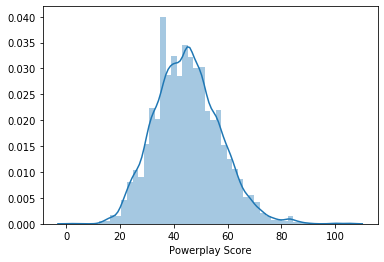

In [35]:


sns.distplot(train_df['Powerplay Score'])
plt.show()

In [34]:
train_df.columns

Index(['Batsman', 'Batter Strike Rate', 'ID', 'Innings', 'Bowler',
       'Economy Rate', 'Powerplay Score', 'Venue', 'batting_team',
       'bowling_team'],
      dtype='object')

In [36]:
# Create a dictionary with venue-wise average powerplay score
# Create a nested dictionary from groupby
venue_pps = train_df.groupby(['Venue', 'Innings'])['Powerplay Score'].mean()
venue_pps_dict = {}
for venue in venue_pps.index.levels[0]:
    innings_dict = {}
    for innings in venue_pps[venue].index:
        innings_dict[innings] = venue_pps[venue][innings]
    venue_pps_dict[venue] = innings_dict
print(venue_pps_dict)
# Map the values in the train_df dataframe
#train_df['Venue_PPS'] = train_df.apply(lambda x: venue_pps_dict[x['Venue']][x['Innings']], axis=1)

{'Arun Jaitley Stadium': {1: 45.45192307692308, 2: 54.2196261682243}, 'Barabati Stadium': {1: 42.8, 2: 42.80281690140845}, 'Brabourne Stadium': {1: 52.857142857142854, 2: 48.17704918032787}, 'Buffalo Park': {1: 39.55555555555556, 2: 38.285714285714285}, 'De Beers Diamond Oval': {1: 41.81818181818182, 2: 38.72727272727273}, 'Dr DY Patil Sports Academy': {1: 43.21442885771543, 2: 44.548463356974}, 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': {1: 40.19117647058823, 2: 40.358108108108105}, 'Dubai International Cricket Stadium': {1: 44.54509803921569, 2: 43.73149741824441}, 'Eden Gardens': {1: 45.70891514500537, 2: 46.816414686825055}, 'Feroz Shah Kotla': {1: 45.06933333333333, 2: 46.699175824175825}, 'Green Park': {1: 50.02127659574468, 2: 59.14545454545455}, 'Himachal Pradesh Cricket Association Stadium': {1: 37.60606060606061, 2: 40.79381443298969}, 'Holkar Cricket Stadium': {1: 42.765765765765764, 2: 59.22222222222222}, 'JSCA International Stadium Complex': {1: 40.492957746478

In [37]:
batting_team_pps = train_df.groupby(['batting_team', 'Innings'])['Powerplay Score'].mean()
batting_team_pps_dict = {}
for venue in batting_team_pps.index.levels[0]:
    innings_dict = {}
    for innings in batting_team_pps[venue].index:
        innings_dict[innings] = batting_team_pps[venue][innings]
    batting_team_pps_dict[venue] = innings_dict
print(batting_team_pps_dict)

# Map the values in the train_df dataframe
#print(batting_team_pps_dict.get('Chennai Super Kings',{}).get(1,0))

#train_df['Batting_Team_PPS'] = train_df.apply(lambda x: batting_team_pps_dict.get(x['batting_team'],{}).get(x['Innings'],-1), axis=1)

#train_df['Batting_Team_PPS'] = train_df.apply(lambda x: batting_team_pps_dict.get((x['batting_team'], x['Innings']), 0), axis=1)
#train_df

{'Chennai Super Kings': {1: 44.17086193745233, 2: 44.348751156336725}, 'Delhi Capitals': {1: 44.72839506172839, 2: 46.41121495327103}, 'Gujarat Titans': {1: 43.70774647887324, 2: 51.527472527472526}, 'Kochi Tuskers Kerala': {1: 44.05, 2: 51.31764705882353}, 'Kolkata Knight Riders': {1: 43.684375, 2: 46.47423398328691}, 'Lucknow Super Giants': {1: 44.11711711711712, 2: 42.951219512195124}, 'Mumbai Indians': {1: 45.060957910014515, 2: 43.564341085271316}, 'Punjab Kings': {1: 45.307063197026025, 2: 47.66028708133971}, 'Rajasthan Royals': {1: 45.136088709677416, 2: 43.215265866209265}, 'Rising Pune Supergiants': {1: 42.02552204176334, 2: 44.113680154142585}, 'Royal Challengers Bangalore': {1: 42.778733385457386, 2: 45.55555555555556}, 'Sunrisers Hyderabad': {1: 43.362004487658936, 2: 47.998360655737706}}


In [38]:
bowling_team_pps = train_df.groupby(['bowling_team', 'Innings'])['Powerplay Score'].mean()
bowling_team_pps_dict = {}
for venue in bowling_team_pps.index.levels[0]:
    innings_dict = {}
    for innings in bowling_team_pps[venue].index:
        innings_dict[innings] = bowling_team_pps[venue][innings]
    bowling_team_pps_dict[venue] = innings_dict
print(bowling_team_pps_dict)
# Map the values in the train_df dataframe
#train_df['Bowling_Team_PPS'] = train_df.apply(lambda x: batting_team_pps_dict.get(x['bowling_team'],{}).get(x['Innings'],-1), axis=1)


{'Chennai Super Kings': {1: 43.5496417604913, 2: 46.5753064798599}, 'Delhi Capitals': {1: 43.507795100222715, 2: 47.65312753858652}, 'Gujarat Titans': {1: 46.62313432835821, 2: 48.40074906367041}, 'Kochi Tuskers Kerala': {1: 36.69117647058823, 2: 49.351351351351354}, 'Kolkata Knight Riders': {1: 45.09238728750924, 2: 45.585585585585584}, 'Lucknow Super Giants': {1: 41.91743119266055, 2: 47.233333333333334}, 'Mumbai Indians': {1: 43.135670731707314, 2: 43.770322580645164}, 'Punjab Kings': {1: 46.07279411764706, 2: 46.39622641509434}, 'Rajasthan Royals': {1: 43.55709342560554, 2: 46.5970695970696}, 'Rising Pune Supergiants': {1: 41.723404255319146, 2: 45.04941176470588}, 'Royal Challengers Bangalore': {1: 44.62491716368456, 2: 46.04169884169884}, 'Sunrisers Hyderabad': {1: 44.31715481171548, 2: 44.01546029515109}}


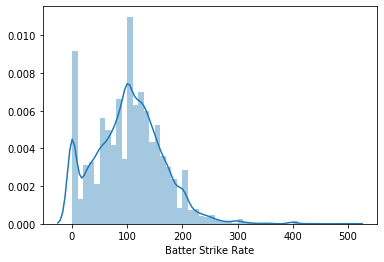

In [39]:
sns.distplot(train_df['Batter Strike Rate'],kde=True)
plt.show()

In [40]:
#Batter Strike Rate
batter_strike_rt_pps = train_df.groupby(['Batsman', 'Innings'])['Batter Strike Rate'].mean()
batter_strike_rt_dict = {}
for venue in batter_strike_rt_pps.index.levels[0]:
    innings_dict = {}
    for innings in batter_strike_rt_pps[venue].index:
        innings_dict[innings] = batter_strike_rt_pps[venue][innings]
    batter_strike_rt_dict[venue] = innings_dict
print(batter_strike_rt_dict)
# Map the values in the train_df dataframe
#train_df['Batter_Srtike_rate_PPS'] = train_df.apply(lambda x: batter_strike_rt_dict.get(x['Batsman'],{}).get(x['Innings'],-1), axis=1)


{'A Ashish Reddy': {2: 71.42857142857143}, 'A Badoni': {1: 16.666666666666664, 2: 0.0}, 'A Chopra': {1: 58.986928104575156}, 'A Flintoff': {2: 93.33333333333333}, 'A Manohar': {2: 100.0}, 'A Mishra': {1: 20.0}, 'A Mukund': {1: 87.5}, 'A Symonds': {1: 72.54007641104415, 2: 51.863354037267094}, 'A Tomar': {2: 50.0}, 'AA Bilakhia': {1: 56.964285714285715, 2: 41.66666666666667}, 'AA Jhunjhunwala': {1: 87.5, 2: 52.59259259259258}, 'AB Agarkar': {2: 133.33333333333331}, 'AB Barath': {2: 128.57142857142858}, 'AB McDonald': {1: 157.89473684210526}, 'AB de Villiers': {1: 128.9406140756066, 2: 90.77062338532923}, 'AC Blizzard': {1: 139.4736842105263, 2: 86.05604921394398}, 'AC Gilchrist': {1: 106.04516630803002, 2: 125.89919303623137}, 'AC Voges': {2: 77.77777777777779}, 'AD Hales': {1: 82.82828282828281, 2: 168.38383838383837}, 'AD Mascarenhas': {2: 200.0}, 'AD Mathews': {1: 58.75, 2: 50.0}, 'AD Nath': {1: 111.11111111111113, 2: 33.33333333333333}, 'AD Russell': {1: 255.55555555555557, 2: 131.2

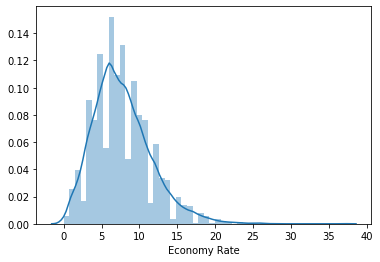

In [41]:
sns.distplot(train_df['Economy Rate'],kde=True)
plt.show()

In [42]:
#Bowler Economy Rate
bowler_ecnmy_rt_pps = train_df.groupby(['Bowler', 'Innings'])['Economy Rate'].mean()
bowler_ecnmy_rt_dict = {}
for venue in bowler_ecnmy_rt_pps.index.levels[0]:
    innings_dict = {}
    for innings in bowler_ecnmy_rt_pps[venue].index:
        innings_dict[innings] = bowler_ecnmy_rt_pps[venue][innings]
    bowler_ecnmy_rt_dict[venue] = innings_dict
print(bowler_ecnmy_rt_dict)
# Map the values in the train_df dataframe
#train_df['Bowler_Economy_rate_PPS'] = train_df.apply(lambda x: bowler_ecnmy_rt_dict.get(x['Bowler'],{}).get(x['Innings'],-1), axis=1)


{'A Ashish Reddy': {2: 20.0}, 'A Chandila': {1: 6.311594202898552, 2: 5.2368421052631575}, 'A Choudhary': {1: 8.571428571428571, 2: 8.6}, 'A Dananjaya': {2: 12.0}, 'A Flintoff': {1: 10.857142857142858}, 'A Kumble': {1: 4.4, 2: 4.875}, 'A Mishra': {1: 6.972222222222221, 2: 9.96774193548387}, 'A Mithun': {1: 13.363636363636363, 2: 6.888888888888889}, 'A Nehra': {1: 7.565555555555557, 2: 7.564516129032258}, 'A Nel': {2: 12.0}, 'A Nortje': {1: 8.590909090909092, 2: 7.569230769230769}, 'A Singh': {1: 6.786324786324785, 2: 6.977477477477477}, 'A Symonds': {1: 5.803571428571429, 2: 4.7727272727272725}, 'A Uniyal': {1: 11.0}, 'A Zampa': {2: 9.0}, 'AA Chavan': {1: 7.029411764705881, 2: 7.216049382716051}, 'AA Jhunjhunwala': {1: 9.636363636363637, 2: 13.0}, 'AA Noffke': {1: 23.0}, 'AB Agarkar': {1: 11.693548387096774, 2: 8.813725490196079}, 'AB Dinda': {1: 7.271028037383177, 2: 7.245833333333334}, 'AB McDonald': {1: 7.5, 2: 9.5}, 'AC Thomas': {1: 6.870370370370369, 2: 6.275}, 'AC Voges': {1: 9.0

In [43]:
final_train_df=train_df.drop(['Economy Rate','Batter Strike Rate'],axis=1)
final_train_df.columns

Index(['Batsman', 'ID', 'Innings', 'Bowler', 'Powerplay Score', 'Venue',
       'batting_team', 'bowling_team'],
      dtype='object')

In [44]:
#bowler_ecnmy_rt_dict.get('SP Narine',{}).get(2,-1)
#bowler_ecnmy_rt_dict
final_train_df

,Batsman,ID,Innings,Bowler,Powerplay Score,Venue,batting_team,bowling_team
0,BB McCullum,335982,1,AA Noffke,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
1,BB McCullum,335982,1,P Kumar,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
2,BB McCullum,335982,1,Z Khan,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
3,RT Ponting,335982,1,AA Noffke,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
4,RT Ponting,335982,1,P Kumar,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
...,...,...,...,...,...,...,...,...
22403,Shubman Gill,1312200,2,TA Boult,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals
22404,Shubman Gill,1312200,2,YS Chahal,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals
22405,WP Saha,1312200,2,M Prasidh Krishna,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals
22406,WP Saha,1312200,2,TA Boult,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals


In [46]:
batsman_df = final_train_df[['Batsman','ID']].rename(columns={'Batsman': 'player_name'}).assign(player_type='Batter')
bowler_df = final_train_df[['Bowler','ID']].rename(columns={'Bowler': 'player_name'}).assign(player_type='Bowler')

result_df = pd.concat([batsman_df, bowler_df], ignore_index=True)
final_train_df_=final_train_df.merge(result_df,on=['ID'],how='inner')

final_train_df_features=final_train_df_.drop_duplicates(subset=['ID', 'Innings','Powerplay Score', 'Venue',
       'batting_team', 'bowling_team', 'player_name', 'player_type'])#'Venue_PPS', 'Batting_Team_PPS',
#'Bowling_Team_PPS', 'Batter_Srtike_rate_PPS', 'Bowler_Economy_rate_PPS',





In [47]:
final_train_df_features_=final_train_df_features[['ID', 'Innings','Powerplay Score', 'Venue',
       'batting_team', 'bowling_team', 'player_name', 'player_type']]#'Venue_PPS', 'Batting_Team_PPS','Bowling_Team_PPS',

final_train_df_features_

,ID,Innings,Powerplay Score,Venue,batting_team,bowling_team,player_name,player_type
0,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,Batter
3,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,RT Ponting,Batter
6,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,Batter
9,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,CL White,Batter
12,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,JH Kallis,Batter
...,...,...,...,...,...,...,...,...
1109850,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,Rashid Khan,Bowler
1109851,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,Yash Dayal,Bowler
1109860,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,M Prasidh Krishna,Bowler
1109861,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,TA Boult,Bowler


In [48]:
final_train_df_features_['Venue_PPS'] = final_train_df_features_.apply(lambda x: venue_pps_dict.get(x['Venue'],{}).get(x['Innings'],-1), axis=1)

C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
final_train_df_features_['Batting_Team_PPS'] = final_train_df_features_.apply(lambda x: batting_team_pps_dict.get(x['batting_team'],{}).get(x['Innings'],-1), axis=1)

In [50]:
final_train_df_features_['Bowling_Team_PPS'] = final_train_df_features_.apply(lambda x: bowling_team_pps_dict.get(x['bowling_team'],{}).get(x['Innings'],-1), axis=1)

In [51]:
final_train_df_features_['Srtike_rate_PPS'] = final_train_df_features_.apply(lambda x: batter_strike_rt_dict.get(x['player_name'],{}).get(x['Innings'],-1), axis=1)

In [52]:
final_train_df_features_['Economy_rate_PPS'] = final_train_df_features_.apply(lambda x: bowler_ecnmy_rt_dict.get(x['player_name'],{}).get(x['Innings'],-1), axis=1)

In [53]:
final_train_df_features_

,ID,Innings,Powerplay Score,Venue,batting_team,bowling_team,player_name,player_type,Venue_PPS,Batting_Team_PPS,Bowling_Team_PPS,Srtike_rate_PPS,Economy_rate_PPS
0,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,Batter,44.115801,43.684375,44.624917,105.092332,-1.000000
3,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,RT Ponting,Batter,44.115801,43.684375,44.624917,37.561328,-1.000000
6,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,Batter,44.115801,43.684375,44.624917,85.185391,14.000000
9,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,CL White,Batter,44.115801,43.684375,44.624917,52.166722,-1.000000
12,335982,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,JH Kallis,Batter,44.115801,43.684375,44.624917,89.648007,8.413842
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109850,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,Rashid Khan,Bowler,48.974359,51.527473,46.597070,-1.000000,8.436170
1109851,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,Yash Dayal,Bowler,48.974359,51.527473,46.597070,-1.000000,10.187500
1109860,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,M Prasidh Krishna,Bowler,48.974359,51.527473,46.597070,-1.000000,7.604167
1109861,1312200,2,31,Narendra Modi Stadium,Gujarat Titans,Rajasthan Royals,TA Boult,Bowler,48.974359,51.527473,46.597070,-1.000000,7.265823


In [54]:
final_train_df_features_eda=final_train_df_features_[['Innings', 'Powerplay Score', 'Venue', 'batting_team',
       'bowling_team', 'Venue_PPS', 'Batting_Team_PPS', 'Bowling_Team_PPS',
       'player_name', 'player_type', 'Srtike_rate_PPS', 'Economy_rate_PPS']]
final_train_df_features_eda.dtypes

Innings               int64
Powerplay Score       int64
Venue                object
batting_team         object
bowling_team         object
Venue_PPS           float64
Batting_Team_PPS    float64
Bowling_Team_PPS    float64
player_name          object
player_type          object
Srtike_rate_PPS     float64
Economy_rate_PPS    float64
dtype: object

In [55]:
final_train_df_features_eda.columns

Index(['Innings', 'Powerplay Score', 'Venue', 'batting_team', 'bowling_team',
       'Venue_PPS', 'Batting_Team_PPS', 'Bowling_Team_PPS', 'player_name',
       'player_type', 'Srtike_rate_PPS', 'Economy_rate_PPS'],
      dtype='object')

## EDA

In [57]:
final_train_df_features_eda.describe()


,Innings,Powerplay Score,Venue_PPS,Batting_Team_PPS,Bowling_Team_PPS,Srtike_rate_PPS,Economy_rate_PPS
count,26210.000000,26210.000000,26210.000000,26210.000000,26210.000000,26210.000000,26210.000000
mean,1.499733,45.757726,45.001991,44.984327,44.989043,62.711664,4.728715
std,0.500009,11.987064,3.317597,1.734365,1.560830,56.264873,4.583113
min,1.000000,2.000000,30.290323,42.025522,36.691176,-1.000000,-1.000000
25%,1.000000,37.000000,42.772296,43.564341,43.770323,-1.000000,-1.000000
50%,1.000000,45.000000,45.069333,44.728395,45.049412,86.068213,6.694030
75%,2.000000,53.000000,46.699176,46.411215,46.396226,107.931088,7.875479
max,2.000000,105.000000,59.222222,51.527473,49.351351,350.000000,24.000000


In [58]:
print(final_train_df_features_eda['batting_team'].value_counts())
print(final_train_df_features_eda['bowling_team'].value_counts())
print(final_train_df_features_eda['Venue'].value_counts())
print(final_train_df_features_eda['player_type'].value_counts())
print(final_train_df_features_eda['player_name'].value_counts())


Mumbai Indians                 3239
Delhi Capitals                 3139
Sunrisers Hyderabad            3117
Kolkata Knight Riders          3102
Royal Challengers Bangalore    3091
Punjab Kings                   3002
Chennai Super Kings            2766
Rajasthan Royals               2639
Rising Pune Supergiants        1054
Gujarat Titans                  649
Lucknow Super Giants            222
Kochi Tuskers Kerala            190
Name: batting_team, dtype: int64
Royal Challengers Bangalore    3292
Punjab Kings                   3246
Mumbai Indians                 3235
Sunrisers Hyderabad            3074
Delhi Capitals                 3017
Kolkata Knight Riders          2993
Chennai Super Kings            2683
Rajasthan Royals               2577
Rising Pune Supergiants        1051
Gujarat Titans                  605
Lucknow Super Giants            246
Kochi Tuskers Kerala            191
Name: bowling_team, dtype: int64
Wankhede Stadium                                       2880
M Chinnasw

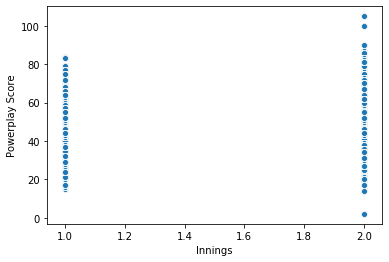

In [59]:
sns.scatterplot(x='Innings', y='Powerplay Score', data=final_train_df_features_eda)

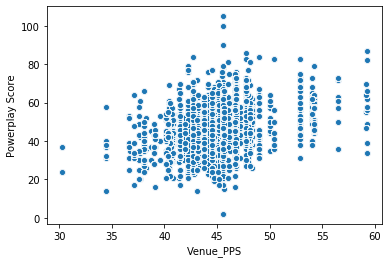

In [60]:
sns.scatterplot(x='Venue_PPS', y='Powerplay Score', data=final_train_df_features_eda)


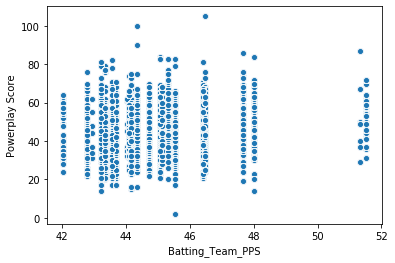

In [61]:
sns.scatterplot(x='Batting_Team_PPS', y='Powerplay Score', data=final_train_df_features_eda)


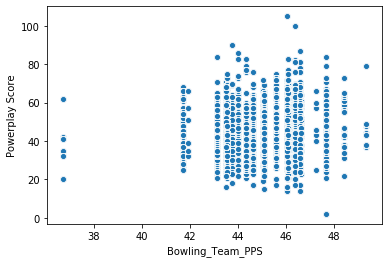

In [62]:
sns.scatterplot(x='Bowling_Team_PPS', y='Powerplay Score', data=final_train_df_features_eda)


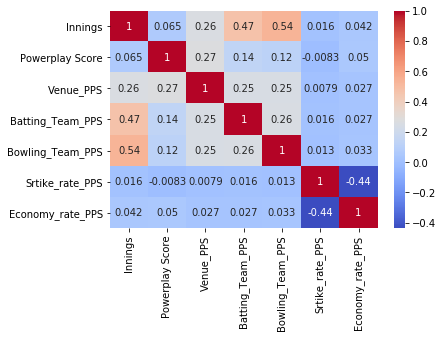

In [63]:
corr = final_train_df_features_eda.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

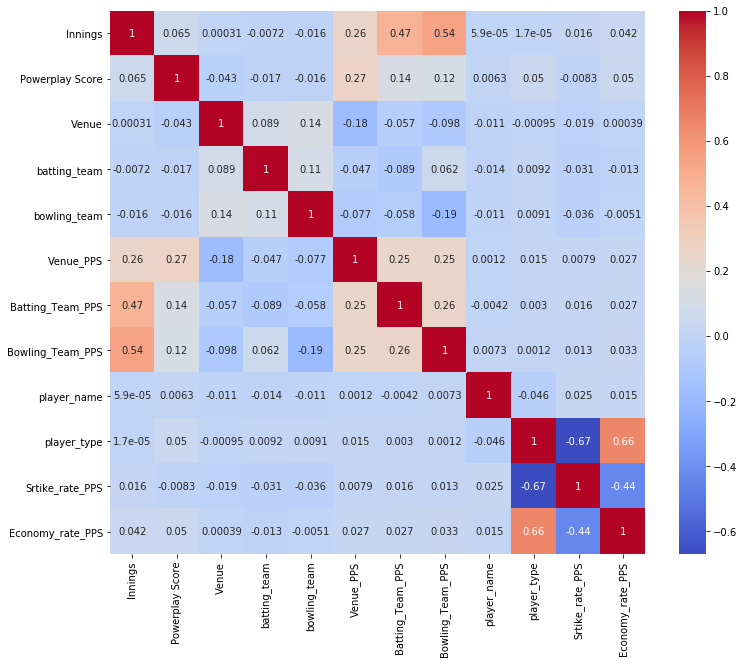

In [91]:


# Create label encoder object
le = LabelEncoder()

# Iterate through all the columns of the dataframe and encode the categorical variables
for col in final_train_df_features_eda.columns:
    if final_train_df_features_eda[col].dtype == 'object':
        final_train_df_features_eda[col] = le.fit_transform(final_train_df_features_eda[col])

num_cols = final_train_df_features_eda.select_dtypes(include=['int64', 'float64']).columns.tolist()
final_train_df_features_importance = final_train_df_features_eda[num_cols]

corr = final_train_df_features_eda.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True)





### FINAL DATA AFTER EDA

In [92]:
final_train_df_features_eda.to_csv('data/intermediate_data/final_features_IPL.csv',index=False)

### FEATURE IMPORTANCE CALCULATION

2 27 52 77 105


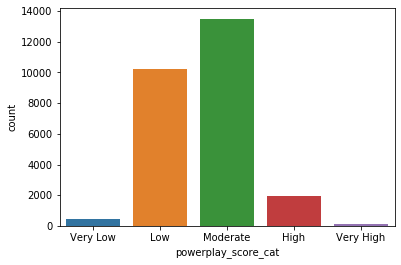

In [110]:
max_scr=final_train_df_features_eda['Powerplay Score'].max()
min_scr=final_train_df_features_eda['Powerplay Score'].min()
print(min_scr,min_scr+25,min_scr+50,min_scr+75,max_scr)

final_train_df_features_eda['powerplay_score_cat'] = pd.cut(final_train_df_features_eda['Powerplay Score'],
                                                           bins=[0,min_scr+20,min_scr+40,min_scr+60,min_scr+80,max_scr],
                                                           labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Split the data into training and testing sets based on powerplay score category
train_data, test_data = train_test_split(final_train_df_features_eda, test_size=0.2, stratify=final_train_df_features_eda['powerplay_score_cat'])

train_data.to_csv('data/intermediate_data/train_data_IPL.csv',index=False)

test_data.to_csv('data/intermediate_data/validation_data_IPL.csv',index=False)


# Separate the target variable and the feature variables


sns.countplot(x='powerplay_score_cat', data=final_train_df_features_eda)

### X & Y Definition

In [116]:
X = train_data.drop(['Powerplay Score','powerplay_score_cat'], axis=1)
y = train_data['Powerplay Score']

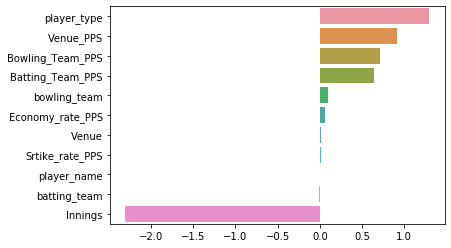

In [113]:


# Train a Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Get the feature importance scores
feat_imp = pd.Series(lin_reg.coef_, index=X.columns).sort_values(ascending=False)

# Plot the feature importance scores
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.show()


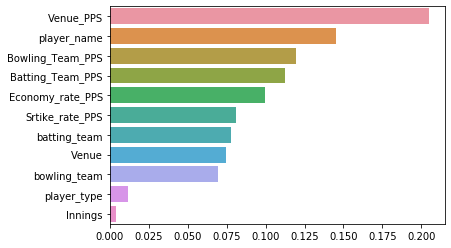

In [114]:


# Train a Decision Tree Regression model
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X, y)

# Get the feature importance scores
feat_imp = pd.Series(dt_reg.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the feature importance scores
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.show()


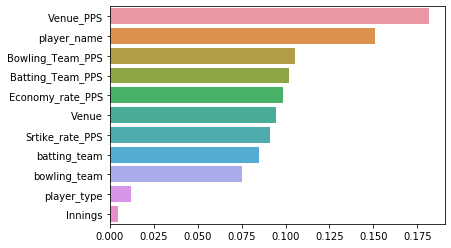

In [117]:
# Train a Random Forest Regression model
rf_reg = RandomForestRegressor()
rf_reg.fit(X, y)

# Get the feature importance scores
feat_imp = pd.Series(rf_reg.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the feature importance scores
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.show()


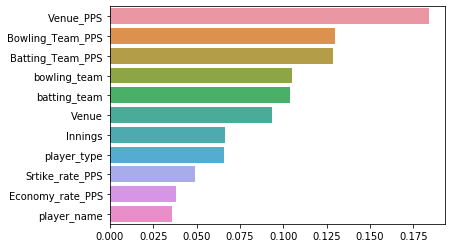

In [118]:
# Train an XGBoost Regression model
xgb_reg = XGBRegressor()
xgb_reg.fit(X, y)

# Get the feature importance scores
feat_imp = pd.Series(xgb_reg.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the feature importance scores
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.show()


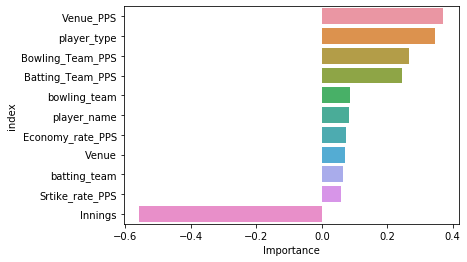

In [119]:
# Combine feature importance scores from four models
all_feature_importances = pd.DataFrame()
for model in [lin_reg, dt_reg, rf_reg, xgb_reg]:
    if(model!=lin_reg):
        feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance']).reset_index()      
    else:
        feature_importances = pd.DataFrame(model.coef_, index=X.columns, columns=['Importance']).reset_index()
        
    feature_importances['Model'] = str(model)
    all_feature_importances = pd.concat([all_feature_importances, feature_importances])
    
# Calculate the mean feature importance score for each feature
mean_feature_importances = all_feature_importances.groupby(['index'])['Importance'].mean().reset_index()

# Sort feature importance scores in descending order
final_feature_importances = mean_feature_importances.sort_values(by='Importance', ascending=False)

sns.barplot(x=final_feature_importances['Importance'], y=final_feature_importances['index'])
plt.show()

In [126]:
final_feature_list=list(final_feature_importances['index'].unique())
final_feature_list_=['Venue_PPS',
 'Bowling_Team_PPS',
 'Batting_Team_PPS',
 'bowling_team',
 'player_name',
 'Venue',
 'Economy_rate_PPS',
 'batting_team',
 'Srtike_rate_PPS','Powerplay Score']

train_data=train_data[final_feature_list_]
test_data=test_data[final_feature_list_]

In [127]:
train_data

,Venue_PPS,Bowling_Team_PPS,Batting_Team_PPS,bowling_team,player_name,Venue,Economy_rate_PPS,batting_team,Srtike_rate_PPS,Powerplay Score
301300,46.699176,46.575306,46.411215,0,192,9,8.031944,1,48.027211,50
195935,40.793814,46.396226,44.348751,7,436,11,8.045045,0,-1.000000,49
200740,44.548463,43.770323,45.555556,6,403,5,-1.000000,10,100.723764,44
753286,44.115801,43.557093,45.136089,8,398,15,-1.000000,8,116.749659,52
274086,43.214429,41.723404,42.025522,9,208,5,-1.000000,9,109.832153,29
...,...,...,...,...,...,...,...,...,...,...
892214,42.723529,45.585586,44.348751,4,491,31,9.208333,0,-1.000000,54
117371,40.724832,45.092387,44.170862,4,24,34,11.693548,0,-1.000000,54
778742,43.094253,46.575306,46.411215,0,256,17,9.000000,1,-1.000000,59
1018770,45.597561,46.575306,46.474234,0,419,36,-1.000000,4,101.141894,43


In [129]:
# encode categorical variables using LabelEncoder and OneHotEncoder
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])

#one_hot_encoders = {}


for column in X.columns:
    if X[column].dtype == 'object':
        one_hot_encoders[column] = OneHotEncoder(sparse=False)
        X_encoded = one_hot_encoders[column].fit_transform(X[column].values.reshape(-1, 1))
        X_encoded_df = pd.DataFrame(X_encoded, columns=[f"{column}_{i}" for i in range(X_encoded.shape[1])])
        X = pd.concat([X.drop(column, axis=1), X_encoded_df], axis=1)
#'''

# split the data using StratifiedKFold to ensure balanced splits
#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#train_indices, test_indices = next(skf.split(X, y))

#X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_train = train_data.drop(['Powerplay Score'], axis=1)
y_train = train_data['Powerplay Score']

X_test = test_data.drop(['Powerplay Score'], axis=1)
y_test = test_data['Powerplay Score']

# fit and evaluate multiple models
models = {
    'ols': LinearRegression(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor()
}

best_model_name = None
best_model_score = float('inf')

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred[0],y_test.values[0])
    
    score = mean_squared_error(y_test, y_pred)
    print(f"{name} score: {score}")
    if score < best_model_score:
        best_model_score = score
        best_model_name = name
        best_model=model
print(f"Best model: {best_model_name} with score: {best_model_score}")


44.98330474793221 38
ols score: 131.21883453508312
38.0 38
decision_tree score: 142.36707029594922
38.65166666666667 38
random_forest score: 94.29581275018248
Best model: random_forest with score: 94.29581275018248


In [130]:
import pickle

In [133]:
# Save the trained model to a file
with open('iit_comp/artifacts/rfr_v2.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [134]:
print(final_feature_list)

['Venue_PPS', 'player_type', 'Bowling_Team_PPS', 'Batting_Team_PPS', 'bowling_team', 'player_name', 'Economy_rate_PPS', 'Venue', 'batting_team', 'Srtike_rate_PPS', 'Innings']


To check if a model is overfitting or not, you can use cross-validation. Cross-validation is a statistical method used to estimate the performance (or accuracy) of machine learning models.

Here's how you can use cross-validation to check if your Random Forest model is overfitting:

Split your dataset into training and testing sets.
Train your Random Forest model on the training set.
Use the trained model to predict the target variable on the testing set.
Calculate the mean squared error (MSE) on the testing set.
Use k-fold cross-validation to evaluate the performance of your model. In k-fold cross-validation, you split the dataset into k equal parts. Then you use k-1 parts to train the model and the remaining part to test the model. You repeat this process k times (with different parts) and calculate the average MSE across all the k-folds.
If the average MSE across all the k-folds is similar to the MSE on the testing set, then your model is not overfitting. If the average MSE across all the k-folds is much higher than the MSE on the testing set, then your model is overfitting.

In [135]:



# split the data using StratifiedKFold to ensure balanced splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_indices, test_indices = next(skf.split(X, y))

X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

# Train the Random Forest model on the training set
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)

# Use the trained model to predict the target variable on the testing set
y_pred = rfc.predict(X_test)

# Calculate the MSE on the testing set
mse_test = mean_squared_error(y_test, y_pred)
print("MSE on testing set:", mse_test)

# Use k-fold cross-validation to evaluate the performance of the model
k = 5  # number of folds
scores = cross_val_score(rfc, X, y, cv=k, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()
print("Average MSE across {}-fold cross-validation: {:.2f}".format(k, mse_cv))

if mse_cv > mse_test:
    print("The model is overfitting")
else:
    print("The model is not overfitting")


MSE on testing set: 95.4747273560326
Average MSE across 5-fold cross-validation: 95.38
The model is not overfitting


Overfitting can be controlled by applying various techniques. Here are a few techniques that you can try:

Regularization: Regularization is a technique used to reduce the complexity of the model. It adds a penalty term to the cost function, which discourages the model from overfitting. The two most common regularization techniques are L1 and L2 regularization.

Cross-validation: Cross-validation is a technique used to evaluate the performance of a model. It involves dividing the data into k-folds, training the model on k-1 folds, and testing it on the remaining fold. This process is repeated k times, and the average performance is calculated.

Early stopping: Early stopping is a technique used to stop the training process before the model overfits the data. It involves monitoring the performance of the model on a validation set and stopping the training process when the performance on the validation set starts to deteriorate.

Feature selection: Feature selection is a technique used to select a subset of features that are most relevant to the target variable. It reduces the complexity of the model and helps to prevent overfitting.

Ensemble methods: Ensemble methods combine multiple models to improve the performance and reduce overfitting. Random Forest and Gradient Boosting are examples of ensemble methods.

You can try one or more of these techniques to control overfitting in your model.

### Prediction Score

In [241]:
pred_feature_df=pd.read_csv('data/test_data/input_test_file.csv')
pred_feature_df

,venue,innings,batting_team,bowling_team,batsmen,bowlers
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,"Quinton de Kock, Rohit Sharma, Suryakumar Yadav","Harbhajan Singh, Varun Chakravarthy, Shakib Al..."
1,MA Chidambaram Stadium,2,Kolkata Knight Riders,Mumbai Indians,"Harbhajan Singh, Varun Chakravarthy, Shakib Al...","Quinton de Kock, Rohit Sharma, Suryakumar Yadav"


In [242]:
pred_feature_df_exploded = pred_feature_df.assign(batsmen=pred_feature_df['batsmen'].str.split(',')).explode('batsmen')
pred_feature_df_exploded_ = pred_feature_df_exploded.assign(bowlers=pred_feature_df_exploded['bowlers'].str.split(',')).explode('bowlers')
pred_feature_df_exploded_

,venue,innings,batting_team,bowling_team,batsmen,bowlers
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Quinton de Kock,Harbhajan Singh
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Quinton de Kock,Varun Chakravarthy
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Quinton de Kock,Shakib Al Hasan
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Quinton de Kock,Pat Cummins
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Rohit Sharma,Harbhajan Singh
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Rohit Sharma,Varun Chakravarthy
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Rohit Sharma,Shakib Al Hasan
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Rohit Sharma,Pat Cummins
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Suryakumar Yadav,Harbhajan Singh
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Suryakumar Yadav,Varun Chakravarthy


In [243]:
pred_feature_df_exploded_.shape

(24, 6)

In [244]:
pred_feature_df_exploded_.columns

Index(['venue', 'innings', 'batting_team', 'bowling_team', 'batsmen',
       'bowlers'],
      dtype='object')

## Data Preparation for Model

In [245]:
batsman_df = pred_feature_df_exploded_[['venue', 'innings','batsmen']].rename(columns={'batsmen': 'player_name'}).assign(player_type='Batter')
bowler_df = pred_feature_df_exploded_[['venue', 'innings','bowlers']].rename(columns={'bowlers': 'player_name'}).assign(player_type='Bowler')

result_df = pd.concat([batsman_df, bowler_df], ignore_index=True)
final_test_df_=pred_feature_df_exploded_[['venue', 'innings', 'batting_team', 'bowling_team']].merge(result_df,on=['venue', 'innings'],how='left')

final_test_df_pred=final_test_df_.drop_duplicates(subset=['innings', 'venue','batting_team', 'bowling_team', 
                                                           'player_name', 'player_type'])

In [246]:
final_test_df_pred.columns

Index(['venue', 'innings', 'batting_team', 'bowling_team', 'player_name',
       'player_type'],
      dtype='object')

In [248]:
final_test_df_pred.columns=['Venue', 'Innings', 'batting_team','bowling_team',
                            'player_name', 'player_type']
final_test_df_pred

,Venue,Innings,batting_team,bowling_team,player_name,player_type
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Quinton de Kock,Batter
4,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Rohit Sharma,Batter
8,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Suryakumar Yadav,Batter
12,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Harbhajan Singh,Bowler
13,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Varun Chakravarthy,Bowler
14,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Shakib Al Hasan,Bowler
15,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Pat Cummins,Bowler
288,MA Chidambaram Stadium,2,Kolkata Knight Riders,Mumbai Indians,Harbhajan Singh,Batter
291,MA Chidambaram Stadium,2,Kolkata Knight Riders,Mumbai Indians,Varun Chakravarthy,Batter
294,MA Chidambaram Stadium,2,Kolkata Knight Riders,Mumbai Indians,Shakib Al Hasan,Batter


In [249]:
final_test_df_pred['Venue'] = final_test_df_pred['Venue'].replace(venue_name_replacements)

C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [250]:
final_test_df_pred['batting_team'] = final_test_df_pred['batting_team'].replace(team_dic)
final_test_df_pred['bowling_team'] = final_test_df_pred['bowling_team'].replace(team_dic)

C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [251]:
import pandas as pd


# define the batsman name

# find the closest match in the dictionary keys using Levenshtein distance
closest_match = min(my_dict.keys(), key=lambda x: Levenshtein.distance(x, batsman_name))

# get the corresponding values from the dictionary
values = my_dict[closest_match]

# print the result
print(f"Key: {closest_match}, Values: {values}")


Key: Ankit Sharma, Values: {1: 116.74965945866018, 2: 119.69308934361428}


In [256]:
final_test_df_pred['Venue_PPS'] = final_test_df_pred.apply(lambda x: venue_pps_dict.get(max(venue_pps_dict.keys(), key=lambda b: jellyfish.jaro_winkler(b, x['Venue'])),{}).get(x['Innings'],-1), axis=1)

final_test_df_pred['Batting_Team_PPS'] = final_test_df_pred.apply(lambda x: batting_team_pps_dict.get(max(bowling_team_pps_dict.keys(), key=lambda b: jellyfish.jaro_winkler(b, x['batting_team'])),{}).get(x['Innings'],-1), axis=1)
final_test_df_pred['Bowling_Team_PPS'] = final_test_df_pred.apply(lambda x: bowling_team_pps_dict.get(max(bowling_team_pps_dict.keys(), key=lambda b: jellyfish.jaro_winkler(b, x['bowling_team'])),{}).get(x['Innings'],-1), axis=1)



C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [257]:

final_test_df_pred['Srtike_rate_PPS'] = final_test_df_pred.apply(lambda x: batter_strike_rt_dict.get(max(batter_strike_rt_dict.keys(), key=lambda b: jellyfish.jaro_winkler(b, x['player_name'])),{}).get(x['Innings'],-1), axis=1)
final_test_df_pred['Economy_rate_PPS'] = final_test_df_pred.apply(lambda x: bowler_ecnmy_rt_dict.get(max(bowler_ecnmy_rt_dict.keys(), key=lambda b: jellyfish.jaro_winkler(b, x['player_name'])),{}).get(x['Innings'],-1), axis=1)

C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [295]:
final_test_df_pred

,Venue,Innings,batting_team,bowling_team,player_name,player_type,Venue_PPS,Batting_Team_PPS,Bowling_Team_PPS,Srtike_rate_PPS,Economy_rate_PPS
0,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Quinton de Kock,Batter,44.733970,45.060958,45.092387,116.749659,8.591503
4,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Rohit Sharma,Batter,44.733970,45.060958,45.092387,97.832692,6.473684
8,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Suryakumar Yadav,Batter,44.733970,45.060958,45.092387,87.500000,8.000000
12,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Harbhajan Singh,Bowler,44.733970,45.060958,45.092387,79.591837,6.667793
13,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Varun Chakravarthy,Bowler,44.733970,45.060958,45.092387,54.151112,6.810811
14,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Shakib Al Hasan,Bowler,44.733970,45.060958,45.092387,75.000000,6.735632
15,MA Chidambaram Stadium,1,Mumbai Indians,Kolkata Knight Riders,Pat Cummins,Bowler,44.733970,45.060958,45.092387,-1.000000,10.172222
288,MA Chidambaram Stadium,2,Kolkata Knight Riders,Mumbai Indians,Harbhajan Singh,Batter,46.747887,46.474234,43.770323,134.815883,7.134568
291,MA Chidambaram Stadium,2,Kolkata Knight Riders,Mumbai Indians,Varun Chakravarthy,Batter,46.747887,46.474234,43.770323,60.389610,5.360000
294,MA Chidambaram Stadium,2,Kolkata Knight Riders,Mumbai Indians,Shakib Al Hasan,Batter,46.747887,46.474234,43.770323,71.688312,7.902778


In [285]:
min(batter_strike_rt_dict.keys(), key=lambda b: Levenshtein.distance(b, 'Suryakumar Yadav'))

'Lalit Yadav'

In [286]:
import pandas as pd
import jellyfish

# define the dictionary
my_dict = {'RG Sharma': {1: 116.74965945866018, 2: 119.69308934361428},
          'Ankit Sharma': {1: 116.74965945866018, 2: 119.69308934361428}}

# define the batsman name
batsman_name = 'Ishant Sharma'

# find the closest match in the dictionary keys using Metaphone algorithm
closest_match =  max(batter_strike_rt_dict.keys(), key=lambda x: jellyfish.jaro_winkler(x, batsman_name))
#print(closest_match)
# get the corresponding values from the dictionary
values = batter_strike_rt_dict[closest_match]

# print the result
print(f"Key: {closest_match}, Values: {values}")


Key: Ishan Kishan, Values: {1: 103.84534360566968, 2: 94.67778542332319}


In [287]:
batter_strike_rt_dict

{'A Ashish Reddy': {2: 71.42857142857143},
 'A Badoni': {1: 16.666666666666664, 2: 0.0},
 'A Chopra': {1: 58.986928104575156},
 'A Flintoff': {2: 93.33333333333333},
 'A Manohar': {2: 100.0},
 'A Mishra': {1: 20.0},
 'A Mukund': {1: 87.5},
 'A Symonds': {1: 72.54007641104415, 2: 51.863354037267094},
 'A Tomar': {2: 50.0},
 'AA Bilakhia': {1: 56.964285714285715, 2: 41.66666666666667},
 'AA Jhunjhunwala': {1: 87.5, 2: 52.59259259259258},
 'AB Agarkar': {2: 133.33333333333331},
 'AB Barath': {2: 128.57142857142858},
 'AB McDonald': {1: 157.89473684210526},
 'AB de Villiers': {1: 128.9406140756066, 2: 90.77062338532923},
 'AC Blizzard': {1: 139.4736842105263, 2: 86.05604921394398},
 'AC Gilchrist': {1: 106.04516630803002, 2: 125.89919303623137},
 'AC Voges': {2: 77.77777777777779},
 'AD Hales': {1: 82.82828282828281, 2: 168.38383838383837},
 'AD Mascarenhas': {2: 200.0},
 'AD Mathews': {1: 58.75, 2: 50.0},
 'AD Nath': {1: 111.11111111111113, 2: 33.33333333333333},
 'AD Russell': {1: 255.55

In [288]:
X_train.columns

Index(['Innings', 'Venue', 'batting_team', 'bowling_team', 'Venue_PPS',
       'Batting_Team_PPS', 'Bowling_Team_PPS', 'player_name', 'player_type',
       'Srtike_rate_PPS', 'Economy_rate_PPS'],
      dtype='object')

In [327]:
final_test_df_pred_=final_test_df_pred[['Innings', 'Venue', 'batting_team', 'bowling_team', 'Venue_PPS',
       'Batting_Team_PPS', 'Bowling_Team_PPS', 'player_name',
       'Srtike_rate_PPS', 'Economy_rate_PPS']]




In [328]:
final_test_df_pred_.dtypes

Innings               int64
Venue                object
batting_team         object
bowling_team         object
Venue_PPS           float64
Batting_Team_PPS    float64
Bowling_Team_PPS    float64
player_name          object
Srtike_rate_PPS     float64
Economy_rate_PPS    float64
dtype: object

## Load Model

In [329]:
# Save the trained model to a file
with open('iit_comp/artifacts/rfr_v2.pkl', 'rb') as f:
    best_model=pickle.load(f)
    

In [330]:
# encode categorical variables using LabelEncoder and OneHotEncoder
label_encoders = {}
for col in final_test_df_pred_.columns:
    #print(col)
    if final_test_df_pred_[col].dtype == 'object':
        print(col)
        final_test_df_pred_[col] = le.fit_transform(final_test_df_pred_[col])

one_hot_encoders = {}

#'''
for column in final_test_df_pred_.columns:
    
    if final_test_df_pred_[column].dtype == 'object':
        print('one hot encoding',col)
        one_hot_encoders[column] = OneHotEncoder(sparse=False)
        X_encoded = one_hot_encoders[column].fit_transform(final_test_df_pred_[column].values.reshape(-1, 1))
        X_encoded_df = pd.DataFrame(X_encoded, columns=[f"{column}_{i}" for i in range(X_encoded.shape[1])])
        X_test = pd.concat([final_test_df_pred_.drop(column, axis=1), X_encoded_df], axis=1)
        
#'''

Venue
batting_team
bowling_team
player_name


C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


'Venue_PPS',
 'Bowling_Team_PPS',
 'Batting_Team_PPS',
 'bowling_team',
 'player_name',
 'Venue',
 'Economy_rate_PPS',
 'batting_team',
 'Srtike_rate_PPS','Powerplay Score'

In [331]:
X_test=X_test.drop(['Innings'],axis=1)
X_test

,Venue,batting_team,bowling_team,Venue_PPS,Batting_Team_PPS,Bowling_Team_PPS,player_name,Srtike_rate_PPS,Economy_rate_PPS
195935,11,0,7,40.793814,44.348751,46.396226,436,-1.000000,8.045045
753286,15,8,8,44.115801,45.136089,43.557093,398,116.749659,-1.000000
9789,15,10,10,44.115801,42.778733,44.624917,505,107.740316,7.283133
1103396,36,10,2,45.597561,45.555556,48.400749,180,39.261905,8.418182
717435,25,6,11,42.205843,45.060958,44.317155,215,-1.000000,6.539106
...,...,...,...,...,...,...,...,...,...
491703,15,10,7,45.546571,45.555556,46.396226,314,-1.000000,7.066358
251401,5,6,9,43.214429,45.060958,41.723404,22,87.500000,9.636364
368898,16,0,6,46.747887,44.348751,43.770323,248,101.642374,-1.000000
556833,25,11,11,42.205843,43.362004,44.317155,308,111.289593,8.666667


## Prediction

In [335]:
y_pred = model.predict(X_test)
final_y_pred=round(y_pred.mean(),0)
print(final_y_pred)

45.0


C:\Users\Sawon\anaconda3\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


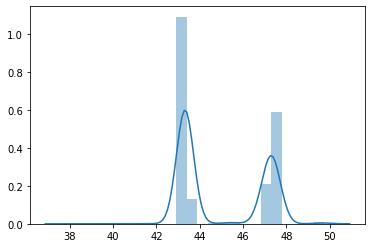

In [333]:
sns.distplot(y_pred,kde=True)
plt.show()

In [46]:
final_train_df_ = train_df_.groupby(['ID', 'Innings']).agg({
    'Batsman': lambda x: ','.join(x),
    'Bowler': lambda x: ','.join(x),
    'Powerplay Score': 'mean',
    'Venue': 'first',
    'batting_team': 'first',
    'bowling_team': 'first'
}).reset_index()

final_train_df_.shape

(1928, 8)

In [49]:
final_train_df_.head

,ID,Innings,Batsman,Bowler,Powerplay Score,Venue,batting_team,bowling_team
0,335982,1,"BB McCullum,BB McCullum,BB McCullum,RT Ponting...","AA Noffke,P Kumar,Z Khan,AA Noffke,P Kumar,Z K...",61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,2,"CL White,CL White,CL White,JH Kallis,JH Kallis...","AB Agarkar,AB Dinda,I Sharma,AB Agarkar,AB Din...",26,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders
2,335983,1,"MEK Hussey,MEK Hussey,MEK Hussey,ML Hayden,ML ...","B Lee,JR Hopes,S Sreesanth,B Lee,JR Hopes,S Sr...",53,Punjab Cricket Association Stadium,Chennai Super Kings,Punjab Kings
3,335983,2,"JR Hopes,JR Hopes,K Goel,K Goel","JDP Oram,MS Gony,JDP Oram,MS Gony",63,Punjab Cricket Association Stadium,Punjab Kings,Chennai Super Kings
4,335984,1,"M Kaif,M Kaif,M Kaif,SR Watson,SR Watson,SR Wa...","B Geeves,GD McGrath,MF Maharoof,B Geeves,GD Mc...",40,Feroz Shah Kotla,Rajasthan Royals,Delhi Capitals


In [55]:

# assuming your data is stored in a pandas DataFrame called "df"
X = final_train_df_[['Batsman', 'Innings', 'Bowler', 'Venue', 'batting_team', 'bowling_team']]
y = final_train_df_['Powerplay Score']

# encode categorical variables using LabelEncoder and OneHotEncoder
label_encoders = {}
for column in ['Batsman', 'Bowler', 'Venue', 'batting_team', 'bowling_team']:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

one_hot_encoders = {}
for column in ['Venue', 'batting_team', 'bowling_team']:
    one_hot_encoders[column] = OneHotEncoder(sparse=False)
    X_encoded = one_hot_encoders[column].fit_transform(X[column].values.reshape(-1, 1))
    X_encoded_df = pd.DataFrame(X_encoded, columns=[f"{column}_{i}" for i in range(X_encoded.shape[1])])
    X = pd.concat([X.drop(column, axis=1), X_encoded_df], axis=1)

# split the data using StratifiedKFold to ensure balanced splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_indices, test_indices = next(skf.split(X, y))

X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

# fit and evaluate multiple models
models = {
    'ols': LinearRegression(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor()
}

best_model_name = None
best_model_score = float('inf')

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred[0],y_test.values[0])
    
    score = mean_squared_error(y_test, y_pred)
    print(f"{name} score: {score}")
    if score < best_model_score:
        best_model_score = score
        best_model_name = name

print(f"Best model: {best_model_name} with score: {best_model_score}")


C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Sawon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


45.28895271183493 26
ols score: 167.95076776693216
47.0 26
decision_tree score: 278.1243523316062
49.35 26
random_forest score: 150.7506670984456
Best model: random_forest with score: 150.7506670984456


In [ ]:
#df_merged = pd.merge(powerplay_df, match_powerplay_total_details, on=['ID','innings'], how='left')